# Introducing Probabilistic Easy Variational Causal Effect: A Fresh Perspective on Causal Inference

Causality refers to the relationship between causes and effects, suggesting that a change in one variable (the cause) directly induces a change in another variable (the effect). Understanding causality is essential across various fields, allowing decision-makers to foresee the consequences of their actions and devise effective policies. Nonetheless, the intricate nature of real-world data often reveals that a single feature may have both positive and negative effects, and its overall influence on outcomes can vary with the feature's prevalence.

In this work, we introduce a novel causal inference model founded on the Total Variation formula. Total Variation quantifies the aggregate changes in a sequence, represented by the sum of the absolute differences between successive data points, such as $|x_1 - x_0|$, as illustrated in the subsequent figure. Our model is adept at quantifying the positive, negative, and total effects of features within a dataset on the outcomes.
<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=13iH8fypKuWHU2vpiDzFK2kVABw3yqqsE' width="600" />
        <figcaption>Total Variation of a Sequence</figcaption>
    </center>
</figure>
Our method for discerning causal relationships is analogous to navigating the highs (positive) and lows (negative) on a rugged path, further enriched with probabilistic elements that reflect the likelihood of event occurrences.

<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1REC72RWaEnLSIsdSauwXxRxdtB9iDf9d' width="600" />
        <figcaption>Negative Total Variation of a Sequence</figcaption>
    </center>
</figure>

The probabilistic aspect of our formula (see below) corresponds to measuring the fluctuations that may indicate the availability—or the likelihood of occurrence—of various elements or events within a causal framework.
This interpretation aligns with the complex nature of real-world data, where a single feature can simultaneously have positive and negative implications, and its overall effect on outcomes can change as the feature's prevalence changes.
<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=11gRcH67wd8jwsChfzITQopgJddUUXEDW' width="600" />
        <figcaption>Probabilistic Total Variation of a Sequence</figcaption>
    </center>
</figure>

In causal inference an intervention or action will lead to different outcomes when various factors are at play. These factors can significantly influence the degree to which our actions affect the desired results. Our approach employs a unique parameter, denoted as $d$, to calibrate the extent to which we account for the availability of change. When $d$ is low, our focus is on the atypical events—the outliers. Conversely, a higher $d$ value indicates an emphasis on more common occurrences. Therefore, rather than confining ourselves to a singular consequence of a cause, we explore an array of potential outcomes, both negative and positive, by adjusting $d$.

<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1ffujDJAnAVRg7JHfNBx1pHo-NuEVp_D8' width="600" />
        <figcaption>Probabilistic Total Variation of a Sequence with degree $d$</figcaption>
    </center>
</figure>


## Related Works
Before introduing our model we will breifly explain an excellent article written by authors in [1] where they used XGBoost model with interpretability tools like SHAP and showed that while interpretability tools effectively reveal the correlations leveraged by machine learning models, do not indicate causality.

To do so, the authors have constructed an XGBoost model to predict customer subscription renewals using eight features. After training, they employed SHAP analysis which revealed counterintuitive patterns; For example, they found that 'Ad Spend' was a strong predictor for customer retention, not because of a direct causal relationship, but because it was correlated with 'Last Upgrade' and 'Monthly Usage'—variables that actually drive retention. This implies that without acknowledging and adjusting for these confounders, predictive models may lead to incorrect conclusions about which factors truly influence outcomes.



This part of the code is taken from [1]


In [ ]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
pip install --upgrade xgboost shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.43.0
    Uninstalling shap-0.43.0:
      Successfully uninstalled shap-0.43.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.15.0 requires shap<0.44.0,>=0.38.1, but you have shap 0.45.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost
import shap

print("SHAP version:", shap.__version__)
print("XGBoost version:", xgboost.__version__)

SHAP version: 0.45.0
XGBoost version: 2.0.3


In [ ]:
# This cell defines the functions we use to generate the data in our scenari

class FixableDataFrame(pd.DataFrame):
    """Helper class for manipulating generative models."""

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

# generate the data
def generator(n, fixed={}, seed=0):
    """The generative model for our subscriber retention example."""
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = (
        (1 - scipy.special.expit(X["Product need"])) * 0.5
        + 0.5 * np.random.uniform(0, 1, size=(n,))
    ) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(
        X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,))
    )

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = (
        X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,))
        + (X["Last upgrade"] < 1)
        + (X["Last upgrade"] < 2)
    )

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v * 2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (
        X["Bugs faced"] * scipy.special.expit(X["Product need"])
    ).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(
        7
        * (
            0.18 * X["Product need"]
            + 0.08 * X["Monthly usage"]
            + 0.1 * X["Economy"]
            + 0.05 * X["Discount"]
            + 0.05 * np.random.normal(0, 1, size=(n,))
            + 0.05 * (1 - X["Bugs faced"] / 20)
            + 0.005 * X["Sales calls"]
            + 0.015 * X["Interactions"]
            + 0.1 / (X["Last upgrade"] / 4 + 0.25)
            + X["Ad spend"]* 0.0
            - 0.45
        )
    )

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X


def user_retention_dataset():
    """The observed data for model training."""
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y


def fit_xgboost(X, y):
    """Train an XGBoost model with early stopping."""
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        {"eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"},
        dtrain,
        num_boost_round=200000,
        evals=((dtest, "test"),),
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    return model

In [ ]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

In [ ]:
X.columns

Index(['Sales calls', 'Interactions', 'Economy', 'Last upgrade', 'Discount',
       'Monthly usage', 'Ad spend', 'Bugs reported'],
      dtype='object')

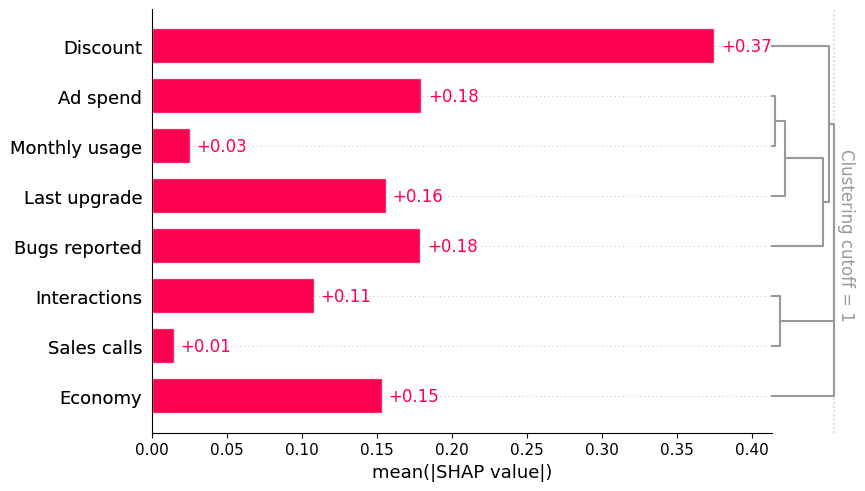

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

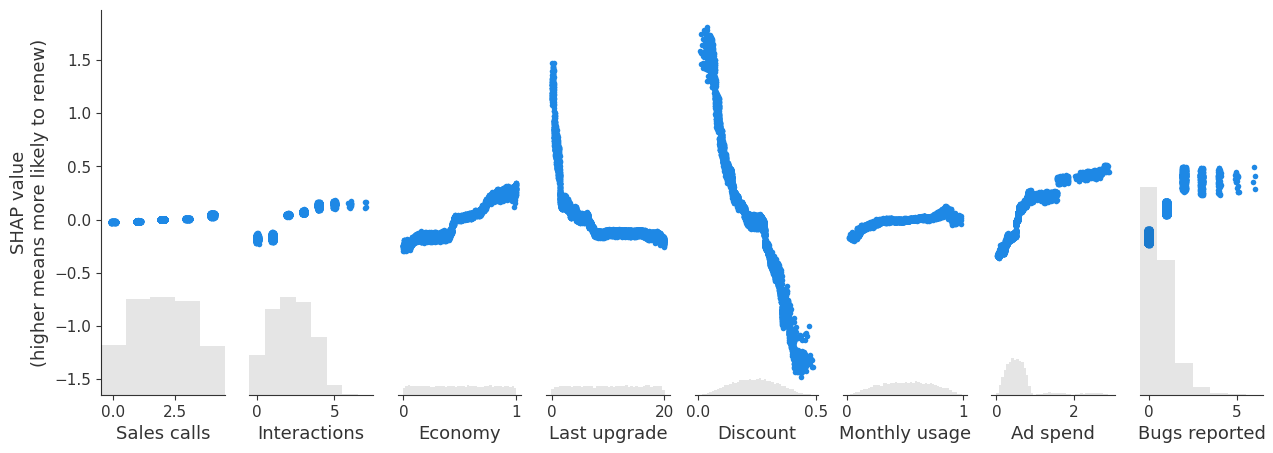

In [ ]:
shap.plots.scatter(
    shap_values, ylabel="SHAP value\n(higher means more likely to renew)"
)

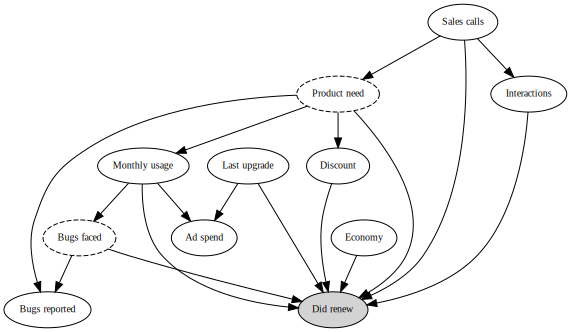

In [ ]:
import graphviz

names = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Ad spend",
    "Interactions",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")
g

This Marginal_effects function is a key component in causal analysis, allowing one to understand how different features individually affect the likelihood of an event ("Did renew" in this case) when their values change across their distributions.

xs[i] is an array of unique values that represent different percentiles of the ith feature's distribution in the dataset. These values will be used to generate new datasets where the feature i is "fixed" to each of these values one at a time to observe the changes in the outcome variable's mean, which is a part of the process to calculate the marginal effects.

In [ ]:
def marginal_effects(
    generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0
):
    """Helper function to compute the true marginal causal effects."""
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))

In [ ]:
result = marginal_effects(generator, 10000, X.columns)
result

# array([0., 1., 2., 3., 4.]) corresponds to "Sales calls" values
#array([-0.4051576, -0.19315068, 0.00074875, 0.22105507, 0.37650446])
#This array represents the centered marginal effects associated with each corresponding feature value from the first array. These effects are "centered" by subtracting the mean effect across all feature values, making the average of these effects zero.
#A feature value of 0 has a marginal effect of approximately -0.405, which suggests that having a feature value of 0 decreases the likelihood of the outcome (e.g., less likely to renew) compared to the average.
#A feature value of 4 has a marginal effect of approximately 0.377, which suggests that having a feature value of 4 increases the likelihood of the outcome (e.g., more likely to renew) compared to the average.

[(array([0., 1., 2., 3., 4.]),
  array([-0.4051576 , -0.19315068,  0.00074875,  0.22105507,  0.37650446])),
 (array([0., 1., 2., 3., 4., 7.]),
  array([-0.22767695, -0.13088572, -0.0563372 ,  0.01054323,  0.08573905,
          0.31861759])),
 (array([3.44944091e-04, 5.10945276e-02, 1.02427889e-01, 1.53826253e-01,
         2.05154271e-01, 2.58615268e-01, 3.11912888e-01, 3.64077975e-01,
         4.19578772e-01, 4.73714566e-01, 5.23947944e-01, 5.75564624e-01,
         6.24850332e-01, 6.80089018e-01, 7.33235301e-01, 7.83198618e-01,
         8.37483645e-01, 8.92475864e-01, 9.47514679e-01, 9.99918744e-01]),
  array([-0.27305556, -0.24436152, -0.21035025, -0.18251059, -0.15351241,
         -0.12688959, -0.10057919, -0.07603148, -0.03968216, -0.00813792,
          0.00701435,  0.03938615,  0.0662943 ,  0.09613928,  0.12160211,
          0.14774325,  0.17588529,  0.21609924,  0.25540145,  0.28954523])),
 (array([5.66233049e-03, 1.16741909e+00, 2.19601234e+00, 3.21438138e+00,
         4.30528292

## Marginal effect function outputs

```
[(array([0., 1., 2., 3., 4.]),
  array([-0.4051576 , -0.19315068,  0.00074875,  0.22105507,  0.37650446]))
```
For each column in the dataset, the marginal effect function outputs two arrays. The first array contains the column's values. For instance, a feature value of 0 has a marginal effect of approximately -0.405, indicating that a feature value of 0 reduces the likelihood of the outcome compared to the average (e.g., it's less likely to renew).

The second  array's values are percentiles.

**If the number of elements in the first table is less than 4, we can see the results.**
A feature value of 4 has a marginal effect of approximately 0.377, which suggests that having a feature value of 4 increases the likelihood of the outcome (e.g., more likely to renew) compared to the average.

## **Total Variation**

Total variation typically quantifies how much the values in the dataset change.

**In functional analysis**, total variation refers to the total amount by which a function increases and decreases over its domain. It is used to describe the complexity of a function in terms of its oscillation.

In the discrete case, Total Variation can measure the sum of the absolute differences between consecutive values in a sequence. For a sequence of values $x_1, x_2, \ldots, x_n$ the total variation $\text{TV}$ is defined as: $\text{TV} = \sum_{i=1}^{n-1} \left| x_{i+1} - x_i \right|$.

The above formula is a starting point to define our causal model.



# Breaking Down Our Model: A Simplified Explanation


Imagine you're studying how a particular treatment (let's call it $T$) affects some outcome (we'll call it $Y$). There's also a third factor involved, a "confounder" ($C$), which could influence both the treatment and the outcome. You can think of this confounder as something that muddles the relationship between the treatment and the outcome, making it hard to tell whether changes in the outcome are truly due to the treatment or something else.

The relationships between these variables can be expressed using some equations, which basically say:


*  The confounder ($C$) is influenced by some factors ($U_C$).
*  The treatment ($T$) is influenced both by the confounder and other factors ($U_T$).

*   The outcome ($Y$) is influenced by the treatment, the confounder, and additional factors ($U_Y$).

Now, suppose you decide to set the treatment to a specific level ($T=t_0$). This act is like stepping in and altering the normal course of things. When you do this, you directly change the treatment without affecting how the confounder comes about but potentially changing the outcome.

There are two ways to think about setting the treatment to $t_0$:


1.   You just set the treatment to $t_0$ and see what happens. This changes the original setup, especially how the outcome $Y$ is determined.
2.   You imagine what would happen if, in the world where the treatment usually depends on the confounder, you could just decide to set the treatment to $t_0$. This thought experiment helps you understand the potential outcome without actually intervening.

We represent the way the outcome $Y$ relates to the treatment $T$ and the confounder $C$  by a function $g$. When you intervene and set $T$ to a specific value (like $t_0$), you're interested in seeing how the outcome $Y$ changes as a result, which is represented by a new function $g_{\text{in}}$ that takes into account the intervention.

To quantify the impact of changing the treatment from one specific level to another (say, from $t_0$ to $t_1$), you can look at the change in the expected outcome. This change gives you an idea of the causal impact of the treatment on the outcome.

The final step involves considering the possibility of changing the treatment across several levels (from $t_0$ to $t_1$, $t_1$ to $t_2$, and so on) and summing up the impacts. This sum gives you a comprehensive measure, called the PEACE of degree $d$, which essentially tells you how the expected outcome varies with different treatment levels, weighted by the probabilities of these levels.

Adding to this, the probabilities of these levels detail how probable each change, say from $t_i$ to $t_{i=1}$, is. These probabilities are known as *the natural availability of changes*. They give insight into how likely it is that the treatment will shift from one specific level to another in the natural course of things, thus offering a quantitative measure to the entire framework of our study. This concept allows us to consider not just the potential outcomes of different treatment levels but also their likelihood, providing a more nuanced understanding of the treatment's causal impact on the outcome.




# Exploring Our Model: A Rigorous Mathematical Perspective

More precisely, assume a simple study of a treatment $T$ on an outcome $Y$ in the presence of a confounder $C$ with the following relationship between the variables:
\begin{align*}
C &= U_C,\\
T &= \alpha C + U_T,\\
Y &= \beta T + \gamma C + U_Y.
\end{align*}
An intervention $T = t_0$ results in the following structural equation model (SEM):
\begin{align*}
C &= U_C,\\
T &= t_0,\\
Y &= \beta T + \gamma C + U_Y.
\end{align*}
<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1RNJShlYsUHL-pg1CuXqr9qEubkKhr5eO
' width="600" />
 </center>
        <figcaption style="text-align: justify;">
The left graph corresponds to the original SEM, while the right graph pertains to the SEM modified by the intervention $T=t_0$. The absence of a direct link from $C$ to $T$ is due to the intervention's universal application across the population, rendering the assignment of $T$ causally independent of $C$. This reflects the intervention's overriding nature, disconnecting any causal influence of $C$  on $T$.
</figcaption>
</figure>
In general, the above equations could be more complicated. Assume that the last equation is $Y = g(T, C)$. Then, after the intervention $T = t_0$, we have $Y(t_0) = g_{\text{in}}(t_0, C)$, where $g_{\text{in}}$ is $g$ after replacing every functional relationship describing $T$ with $T = t_0$. Now, a causal change of $Y$ under the change from $T = t_0$ to $T = t_1$ could be obtained as follows:
\begin{equation*}
|\mathbb{E}[g_{\text{in}}(t_1, C)] - \mathbb{E}[g_{\text{in}}(t_0, C)]|
\end{equation*}
By adding the availability of changing from $t_0$ to $t_1$ of degree *d*, we will have:
\begin{equation*}
|\mathbb{E}[g_{\text{in}}(t_1, C)] - \mathbb{E}[g_{\text{in}}(t_0, C)]| \cdot P(t_1)^d \cdot P(t_0)^d
\end{equation*}
Finally, if we sort the values of $T$ as $t_0 < t_1 < \cdots < t_l$, then we can define the PEACE of degree $d$ of $T$ on $Y$ as below:
\begin{equation*}
\sum_{i=1}^{l} |\mathbb{E}[g_{\text{in}}(t_i, C)] - \mathbb{E}[g_{\text{in}}(t_{i-1}, C)]| \cdot P(t_i)^d \cdot P(t_{i-1})^d
\end{equation*}


# A Visual Example of Intervention

As an example, assume that $T$ takes non-negative integers and $Y= g(T,C) = a_T + C$ and $T = C$, where $a_T$ is the above sequence. In the absence of intervention, the difference is given by
\begin{equation*}
|\mathbb{E}[g(t_1, C)] - \mathbb{E}[g(t_0, C)]| = |(a_{t_1} + t_1) - (a_{t_0} + t_0)|,
\end{equation*}
whereas, with an intervention set at $T = t$, the SEM is updated to:
\begin{equation*}
Y = g_{\text{in}}(T, C) = a_T + C, \quad T = t.
\end{equation*}
It's important to note that while the functions $g$ and $g_{\text{in}}$ appear functionally similar, in $g$, we have $T = C$, whereas, in $g_{\text{in}}$, $T$ and $C$ are independent.
 Hence,
we have that
\begin{equation*}
|\mathbb{E}[g_{\text{in}}(t_1, C)] - \mathbb{E}[g_{\text{in}}(t_0, C)]| = |(a_{t_1}+\mathbb{E}(C)) - (a_{t_0}+\mathbb{E}(C))| = |a_{t_1} - a_{t_0}|.
\end{equation*}

<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1FQRX_p7M5n6mj5NIWBdrITQwvPWplp2e
' width="600" />
        <figcaption>The left-hand graph represents $Y$ before any intervention, where $\Delta Y$ is the absolute difference $|\mathbb{E}[g(t_1, C)] - \mathbb{E}[g(t_0, C)]|$. The right-hand graph shows $Y$ after the intervention. Given a specific intervention at $T = t$, the expected values at the points of intersection with the vertical line at $T = t$ are represented by $\mathbb{E}(g_{\text{in}}(t, C))$. Here, $\Delta Y$ is defined as $|\mathbb{E}[g_{\text{in}}(t_1, C)] - \mathbb{E}[g_{\text{in}}(t_0, C)]|$ by assumming that $\mathbb{E}(g_{\text{in}}(t_0, C))$ and $\mathbb{E}(g_{\text{in}}(t_1, C))$ happen at the large orange and green points, respectively.

</figcaption>
    </center>
</figure>


# An Example to Illustrate the Interpretation of Degree $d$

Assume that $Y=g(T,X, \ldots)$ and we want to calculate the causal effects of $T$ and $X$ on the outcome $Y$. We start with $T$. Assume that
	\begin{equation*}
  T\in\{0,1,2\},\quad P(T=0)= \frac{1}{5},\quad P(T=1)= P(T=2) = \frac{2}{5}
  \end{equation*}
	and
\begin{equation*}
\mathbb{E}(Y(T=0)) = 0,\quad \mathbb{E}(Y(T=1)) = 1,\quad \mathbb{E}(Y(T=2)) =2
 \end{equation*}
	Then
	\begin{align*}
		\mathbb{PEACE}_d(T\to Y) &=4^d|\mathbb{E}(Y(T=1))-\mathbb{E}(Y(T=0))|\mathbb{P}(T=1)^d\mathbb{P}(T=0)^d\\
		&+4^d|\mathbb{E}(Y(T=2))-\mathbb{E}(Y(T=1))|\mathbb{P}(T=2)^d\mathbb{P}(T=1)^d\\
		&=4^d|1-0|\left(\frac{1}{5}\right)^d\left(\frac{2}{5}\right)^d+4^d|2-1|\left(\frac{2}{5}\right)^d\left(\frac{2}{5}\right)^d \\
		&=\frac{8^d}{25^d}+\frac{16^d}{25^d}.
  \end{align*}
Now, consider the following setting for $X$:
	\begin{equation*}
  X\in\{0,1,2\},\quad P(X=0)= \frac{1}{9},\quad P(X=1)= P(X=2) = \frac{4}{9}
  \end{equation*}
	and
	\begin{equation*}
  \mathbb{E}(Y(X=0)) = 0,\quad \mathbb{E}(Y(X=1)) = 1,\quad \mathbb{E}(Y(X=2)) =2
  \end{equation*}
	Then
	\begin{align*}
		\mathbb{PEACE}_d(X\to Y) &=4^d|\mathbb{E}(Y(X=1))-\mathbb{E}(Y(X=0))|P(X=1)^dP(X=0)^d\\
		&+4^d|\mathbb{E}(Y(X=2))-\mathbb{E}(Y(X=1))|P(X=2)^dP(X=1)^d\\
		&=4^d|1-0|\left(\frac{1}{9}\right)^d\left(\frac{4}{9}\right)^d+4^d|2-1|\left(\frac{4}{9}\right)^d\left(\frac{4}{9}\right)^d \\
		&=\frac{16^d}{81^d}+\frac{64^d}{81^d}.
	\end{align*}
Hence, we have that
\begin{equation*}
  \mathbb{PEACE}_d(T\to Y) = \underbrace{\left(\frac{8^d}{25^d}\right)}_{less\; likely}+\underbrace{\left(\frac{16^d}{25^d}\right)}_{more\;likely}
\end{equation*}
which implies that
\begin{equation*}
\frac{more\;likely}{less\;likely} (T)= \dfrac{\dfrac{16^d}{25^d}}{\dfrac{8^d}{25^d}} = 2^d.
\end{equation*}

**As $d$ increases, the impact of the more likely availability becomes more pronounced relative to the less likely availability.**

Similarly, we have that
\begin{equation*}
\mathbb{PEACE}_d(X\to Y) = \underbrace{\left(\frac{16^d}{81^d}\right)}_{less\; likely}+\underbrace{\left(\frac{64^d}{81^d}\right)}_{more\;likely}
\end{equation*}
which implies that
\begin{equation*}\frac{more\;likely}{less\;likely} (X)= \dfrac{\dfrac{64^d}{81^d}}{\dfrac{16^d}{81^d}} = 4^d.
\end{equation*}
Therefore, this proportionality for $X$ is $2^d$ times faster than that for $T$.

<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1XjALV9zjXAXwdq0ulYnMZNLQHCyb4Snt
' width="500" />
        <figcaption style="text-align: justify;">
The blue plot illustrates the proportionality (more likely)/(less likely) for $X$, while the red plot does the same for $T$.
        </figcaption>
   </center>
</figure>

<figure>
    <center>
        <img src='https://drive.google.com/uc?export=view&id=1RjtJKMWq0Y9OzQg334e8XV8wwGfa7QRe
' width="500" />
        <figcaption style="text-align: justify;">
The blue plot illustrates $\mathbb{PEACE}_d(X\to Y)$, while the red plot does the same for $T$. As observed, the gap between the two graphs widens, indicating that they are moving away from each other, a reflection of the exponentially increasing disparity in their above proportionalities.
        </figcaption>
   </center>
</figure>

# Mean PEACE

Let's consider the task of measuring the causal effect of $T$ on $Y$. Assume $t_0 < t_1 < \cdots < t_l$ represent all possible values of $T$. Within the framework of the PEACE formula, we account for minor variations in $X$ along the sequence $t_0, \ldots, t_l$, enabling the assessment of outcome changes. The probability of the availability of each incremental change from each treatment value to the next value (i.g., $t_0$ to $t_1$)  is calculated. Then, the **total** causal effect of $T$ on $Y$, with respect to slight incremental changes, is calculated as PEACE.

Now, instead of a total causal effect formula, we can think of an **average** causal effect formula by focusing exclusively on adjacent changes of the treatment value. Therefore, we call this new causal effect metric MEAN PEACE, and we calculate it by dividing the PEACE value by the **total natural availability of changing of degree $d$ of the treatment value**, defined as
$$\sum_{i=1}^{l} P(t_i)^d  P(t_{i-1})^d.$$
Therefore, we have that
$$ \mathrm{MEAN}-\mathbb{PEACE}_d(T\to Y):=\sum_{i=1}^l|\mathbb{E}(g_{in}(t_i, C)) - \mathbb{E}(g_{in}(t_{i-1}, C))|\left(\frac{P(t_i)^d P(t_{i-1})^d}{\sum_{j=1}^{l} P(t_j)^d  P(t_{j-1})^d}\right)$$.

MEAN PEACE proves advantageous in experimental designs due to the conductor's ability to actively intervene, where the feasible modifications are limited to consecutive, incremental changes. On the contrary, within the realm of observational studies, PEACE emerges as the preferred metric. This preference stems from the importance of the frequency at which treatment values occur, thus prioritizing the evaluation of each transition from $t_i$ to $t_{i+1}$ across the entire spectrum of possible alterations. The key difference between PEACE and MEAN PEACE lies in how each formula accounts for the distribution of treatment levels: the PEACE formula emphasizes total effect size, possibly skewed by more common transitions, while the MEAN PEACE formula emphasizes the average effect size, normalized by the frequency of transitions.







The following  code defines a function, `fit_kde_and_get_pdf`, which takes a dataset columns as input and fits a Kernel Density Estimation (KDE) model to it. KDE is a way to estimate the probability density function (PDF) of a continuous random variable. It is used for non-parametric analysis, providing a smooth estimate of the distribution from which the sample is drawn. The function uses the `KernelDensity` class from the `sklearn.neighbors` module to fit the KDE model with a Gaussian kernel and a specified bandwidth of 0.5.

Here's a step-by-step explanation of what the code does:

1. **Reshape Data**: The input column data is reshaped into a 2D array since scikit-learn expects data in this format. This is necessary because the KDE functionality in scikit-learn is designed to work with multiple features, even though, in this case, we're only working with one.

2. **Fit the KDE Model**: A KDE model with a Gaussian kernel and a bandwidth of 0.5 is fitted to the reshaped data. The bandwidth parameter controls the smoothness of the resulting density estimate.

3. **Define PDF Function**: After fitting the KDE model to the data, a function `pdf` is defined. This function takes an input `x` and returns the estimated density at that point. It uses the `score_samples` method of the fitted KDE object, which returns the log density of the input sample. The `np.exp` function is applied to convert this back to the density value.

4. **Return PDF Function**: The function `fit_kde_and_get_pdf` returns the `pdf` function, which can be used to compute the probability density at any point.

The code then creates a dictionary, `pdf_functions`, to store the PDF function for each column in a given dataset (`user_retention_dataset()[0]`). It iterates over each column in the dataset, fits a KDE model to the column data, and stores the resulting PDF function in the dictionary.


In [ ]:
from sklearn.neighbors import KernelDensity

def fit_kde_and_get_pdf(column_data):
    # Reshape data for sklearn (it expects a 2D array)
    data = column_data.values.reshape(-1, 1)

    # Fit the KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)

    # Define a function to represent the PDF using the KDE
    def pdf(x):
        return np.exp(kde.score_samples([[x]]))[0]

    return pdf

# Dictionary to hold the PDF functions for each column
pdf_functions = {}

data = user_retention_dataset()[0]
for column in data:
    pdf_functions[column] = fit_kde_and_get_pdf(data[column])

# Now, pdf_functions contains a function for each column that computes the probability density.

### In the following code:

**Initialization**: A dictionary peace is initialized to store the aggregated causal effect for each variable in the dataset.

**Iterating Over Columns**: The function iterates over the columns of the data DataFrame, representing different variables.

**Index Retrieval**: For each variable, it finds its position in the DataFrame's column list using get_loc.

**Aggregation of Effects:** It sets an accumulator effect to zero for each variable. This accumulator will sum up the weighted effects across pairs of data points.

**Loop Over Data Points**: The function loops over pairs of consecutive data points from a result object. This object is presumed to contain an array of data points where the effects are computed and an array of their corresponding marginal effects.

**Effect Weighting:** For each consecutive pair of data points, it calculates the absolute difference in their effects. This difference is then weighted by a term (4*(pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d). This term involves the probability densities of the data points (retrieved via pdf_functions), multiplied by 4, and raised to the power of d [2]. This power transformation adjusts the weighting based on the degree of availibity d.

```python
        result[index][0]: correspond to [(array([0., 1., 2., 3., 4.]), in the marginal effect code
        result[index][1]: array([-0.4051576 , -0.19315068,  0.00074875,  0.22105507,  0.37650446]))
```

**Effect Summation**: The weighted effect differences are summed up to form the total effect for each variable.

**Storing Aggregated Effects**: After processing all data points, the total effect for each variable is stored in the peace dictionary.

**Return PEACE Values**: The function returns the peace dictionary, which now holds the aggregated causal effects for each variable, taking into account the degree of variability in their effects.

In [ ]:
def PEACE(d):
  peace = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += abs(result[index][1][i] - result[index][1][i-1])*(4*(pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d)
    peace[c] = effect
  return peace

**Define Step Size and Length**

*   **step** is set to 0.01, indicating the increment between each $d$ value in the sequence.
*  **length** calculates how many steps are needed to go from 0 to 1 inclusive, based on the step size.

**Generate $d$_values**

*   **d_values** is created using np.linspace(0, 1, length), generating a NumPy array of values starting from 0 to 1, inclusive, with a total of length numbers. Since length = int(1/step) + 1, it ensures that 0 and 1 are included in the array, and the total count of values equals length.

**Compute peace_values Dictionary**


*   For each column c in the DataFrame data, it computes a list of values. Each value in the list corresponds to the result of PEACE(d)[c] for each d in d_values.
*  The comprehension [PEACE(d)[c] for d in d_values] iterates over each d, computes PEACE(d), and extracts the result for column c.

In [ ]:
step = 0.01
length = int(1/step) + 1
d_values = np.linspace(0, 1, length)
peace_values = {c: [PEACE(d)[c] for d in d_values] for c in data.columns}

The provided code consists of two main components: the definition of `Availability(d)` and subsequent computations involving this function's results.

1. **`Availability(d)` Function**:
   This function calculates the "availability" score for each column (i.e., total natural availability of changing  the value of each column) and returns a dictionary where each key is a column name, and the corresponding value is the calculated availability score for that column.

2. **`availability_values` Dictionary**:
   For each column, it generates a list of availability scores by calling `Availability(d)` for each `d` value in the array `d_values`.

3. **`mean_peace_values` Dictionary**: After computing `availability_values`, this code calculates `mean_peace_values` for each column by dividing the array of `peace_values[c]` by the corresponding `availability_values[c]` for each column `c`. This is done element-wise, as both `peace_values[c]` and `availability_values[c]` are lists (converted to numpy arrays for this operation) of values calculated for the same `d_values`.



In [ ]:
def Availability(d):
  availability = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    availability[c] = 0
    for i in range(1, len(result[index][0])):
      availability[c] += (4*(pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1])))**d
  return availability

availability_values = {c: [Availability(d)[c] for d in d_values] for c in data.columns}
mean_peace_values = {c: np.array(peace_values[c]) / np.array(availability_values[c]) for c in data.columns}

Now, we visualize PEACE and MEAN PEACE for each input column.

1. **Setup**: Initializes a figure with a 3x2 grid of subplots using `plt.subplots`, specifying the figure size.

2. **`plot_values` Function**: A versatile function for plotting. It adjusts the plotting range for "second derivative" plots to account for the reduced data range after derivative calculations (that will be used later). It then generates plots on specified axes, customizing the x-labels, y-labels, titles, and legends based on input parameters.

3. **Plotting Loops**: Uses predefined ranges to plot data from `peace_values` and `mean_peace_values` across the subplot grid.

4. **Finalization**: Adjusts the layout for better readability and displays the generated plots.



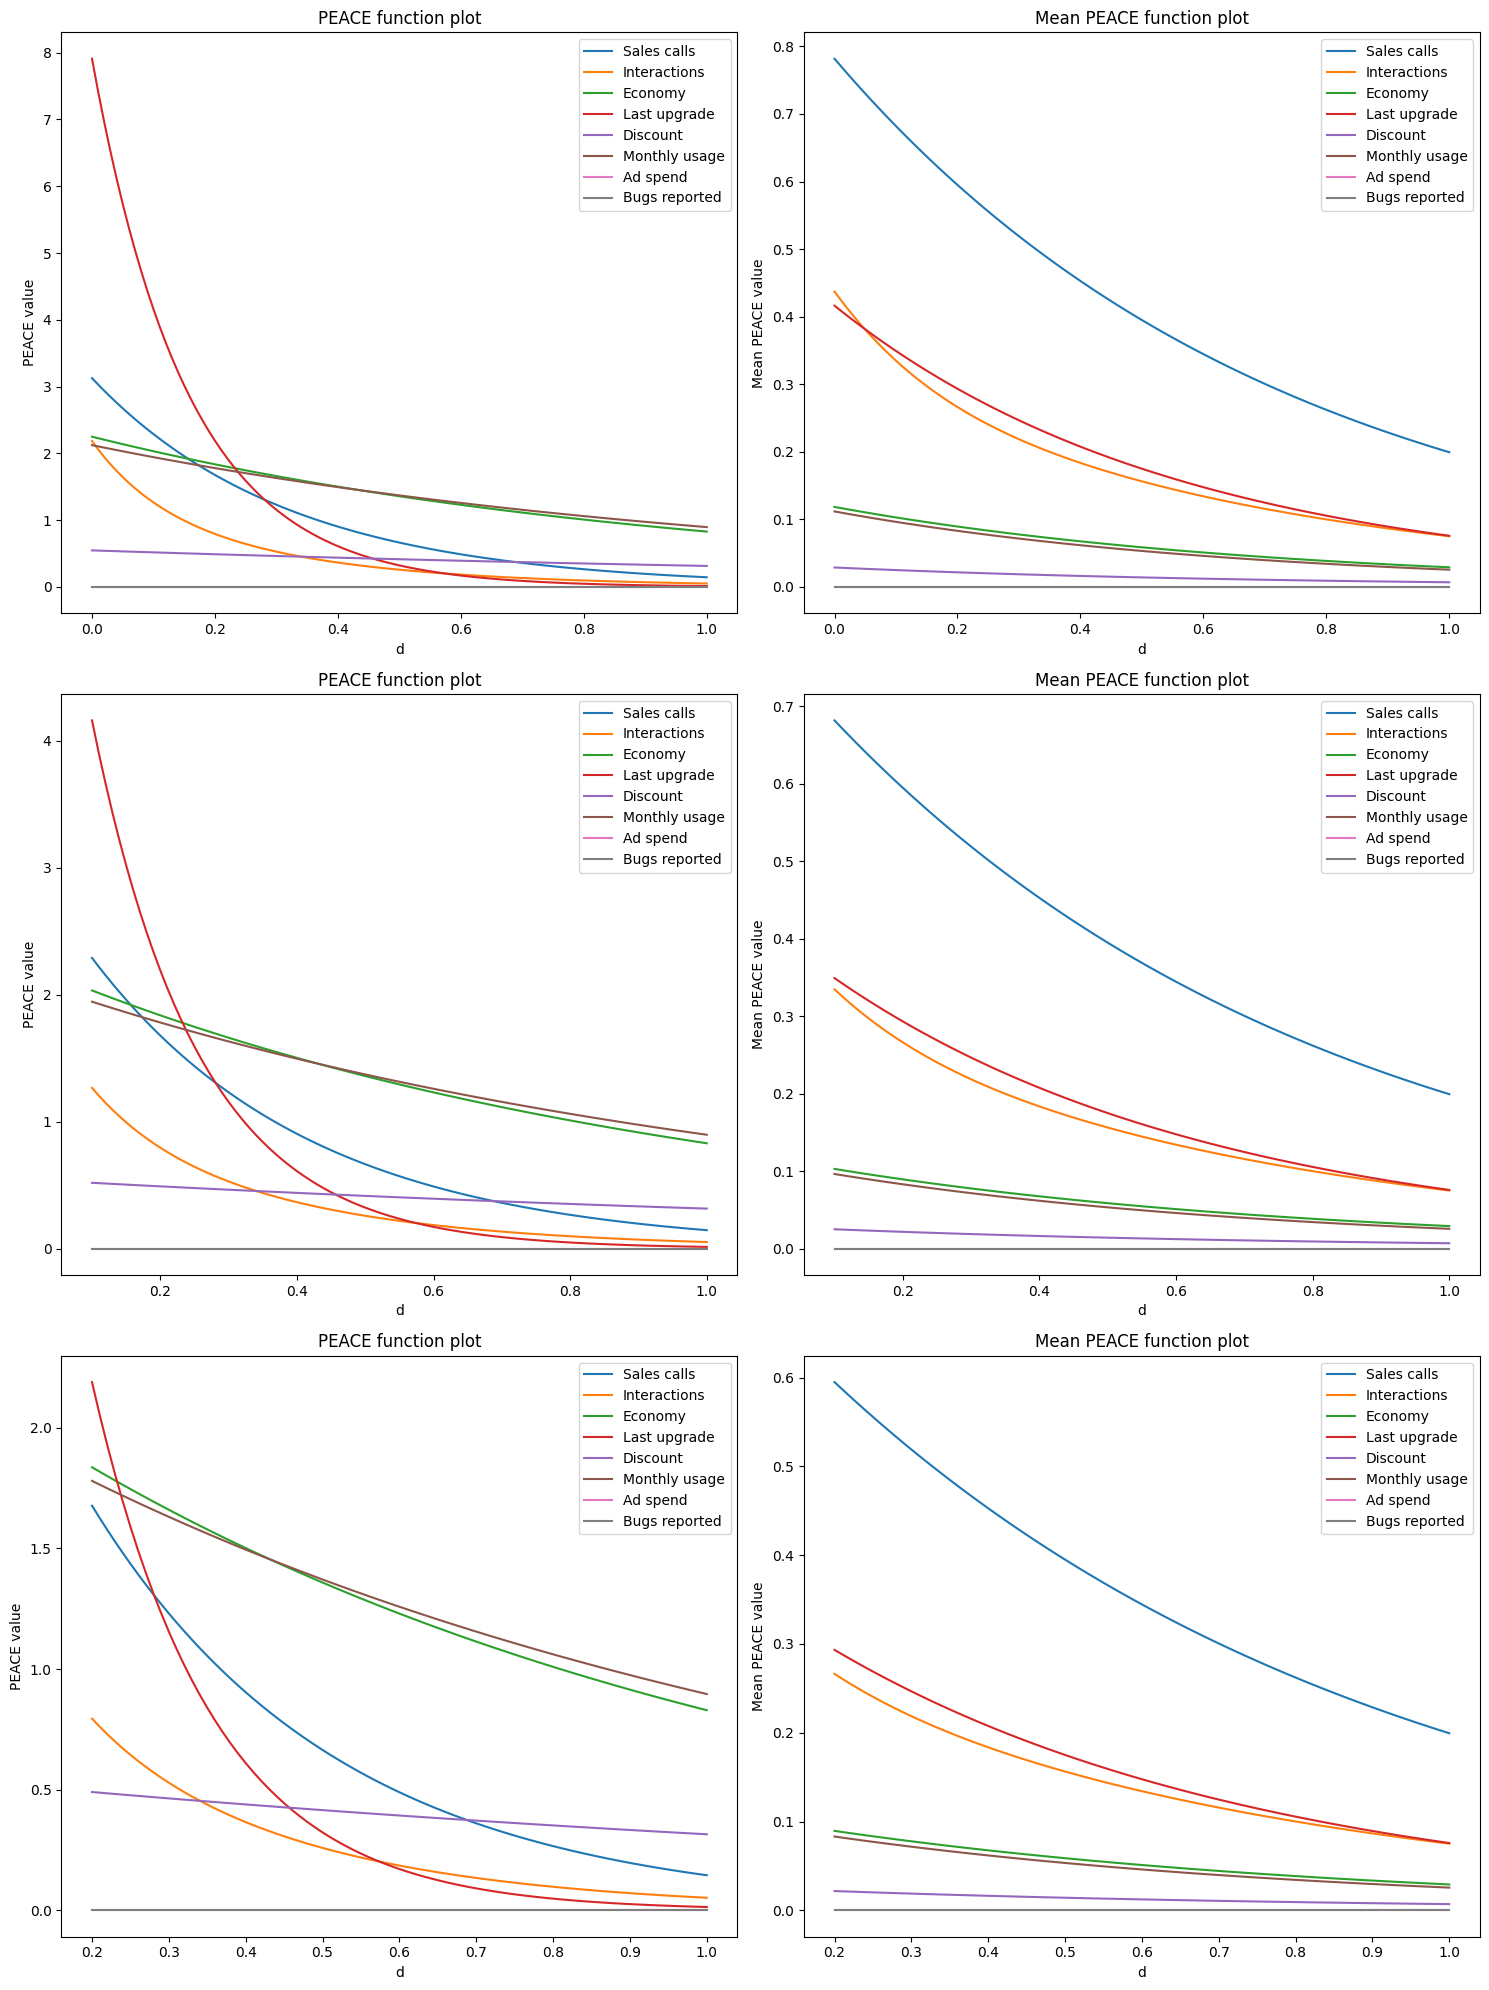

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 20))

def plot_values(type, ax, values_dict, start, end, step, ylabel, title):
  if type == 'ordinary':
    end_new = end
  elif type == 'second derivative':
    end_new = end - 2*step
  length_temp = int((end_new - start) / step)+1
  for c in values_dict:
    x_values = np.linspace(start, end_new, length_temp)
    y_values = values_dict[c][int(start/step):]
    ax.plot(x_values, y_values, label=c)
  ax.set_xlabel('d')
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.legend()

plot_ranges = [(0, 1), (0.1, 1), (0.2, 1)]
for i, (start, end) in enumerate(plot_ranges):
    plot_values('ordinary', axs[i, 0], peace_values, start, end, step, 'PEACE value', 'PEACE function plot')
    plot_values('ordinary', axs[i, 1], mean_peace_values, start, end, step, 'Mean PEACE value', 'Mean PEACE function plot')

plt.tight_layout()
plt.show()

**Some Important Points About PEACE**

*   Increased Sensitivity with Lower $d$: The pronounced steepness observed in the graph for lower values of $d$ indicates heightened sensitivity to less frequent events. For example, the "Last Upgrade" event displays a notably high PEACE value when $d$ is low, suggesting that infrequent upgrades play a crucial role in influencing the outcome. This pronounced steepness implies that the probability values associated with the "Last Upgrade" event (as depicted in the association image) are significantly smaller compared to those of sales calls.


*   Convergence at Higher $d$: As $d$ increases, the PEACE values for all variables seem to converge, indicating that when common events are given more weight, the distinctiveness of each variable's impact on the outcome diminishes.


*   Variable Influence: The initial steepness and the subsequent rate of decline for each graph offer insights into the changing influence of each variable. For instance, "Sales Calls" and "Interactions" begin at a lower point on the Y-axis and exhibit a more gradual decline, indicating a steadier effect across varying levels of event frequency.


**What does it mean if the graph of the PEACE of a variable on outcome has a very steep slope?**

There's significant heterogeneity in the probability distribution of treatment levels ($P(t_i)$), with some levels being much more common than others. This indicates a wide variance in the frequency of each treatment level, with certain treatments occurring much more frequently than others. Consequently, the causal effects between adjacent treatment levels vary substantially in size. The adjustment of the weighting factor $d$ plays a critical role in how these differences are accentuated or minimized. For lower values of $d$, the formula tends to give a more balanced weight across transitions between treatment levels. However, as $d$ increases, the weighting mechanism increasingly emphasizes the causal effects involving more common treatment levels and de-emphasizes those involving less frequent levels. This results in a dramatic alteration in the focus on the size of causal effects based on the commonality of the treatment levels as $d$ is varied. **Insights into these dynamics can be further enhanced by examining the curvature of the PEACE and MEAN PEACE functions, which we will explore later using the second derivatives of these functions.**


**What do the differing results between PEACE and MEAN PEACE indicate?**

Let's clarify the difference by focusing on `sales calls`. **We observe that the MEAN PEACE of sales calls on the outcome is significant, yet for the PEACE, it is not.** This observation indicates that the probabilities of transitioning from one value of sales calls to the next (e.g., from 0 to 1, 1 to 2, etc.) vary considerably. Consequently, by averaging, the new terms, which consist of the probability values, increase, and thus the effects of them together with their coefficients (i.e., $\mathbb{E}[g_{\text{in}}(t_1, C)] - \mathbb{E}[g_{\text{in}}(t_0, C)]$) also increase.

More precisely, the possible values for sales calls are 0, 1, 2, 3, 4, with corresponding probabilities of occurrence being 0.125, 0.25, 0.25, 0.25, 0.125, respectively. Therefore, the values of $P(i)P(i-1)$ for $i=1,2,3,4$ for sales calls are 0.03125, 0.0625, 0.0625, 0.03125. This results in the first and the last values being half of the two middle terms, indicating these values are significantly different from each other. Consequently, the availability score is 0.1875, which is relatively low, leading the new terms of probability ($P(i)P(i-1)/\sum_{j=1}^4 P(j)P(j-1)$ for $i=1,2,3,4$) to be approximately 0.16667, 0.33333, 0.33333, 0.16667, respectively. If we apply the same interpretation and procedure to other variables, their MEAN PEACE compared to PEACE do not increase in the same manner as the causal effect of sales calls does.

**In this analysis, it is observed that, consistent with reality, the causal effect of Ad Spend is zero, which contrasts with interpretations derived from Shapley values.**


The following block introduces a function, `calculate_derivative`, to compute numerical derivatives for data stored in dictionaries, where each key corresponds to a distinct variable. The derivatives are calculated using a straightforward difference quotient method, appropriate for evenly spaced data points.

### Key Components:

- **`calculate_derivative` Function**: Automates the derivative calculation process across a dataset. It iterates through each variable in the input dictionary, computing the difference between consecutive data points and dividing by the measurement interval (`step`), effectively yielding the rate of change for each data point.

- **Application to Datasets**: The function is employed to calculate both the first and second derivatives of  `peace_values` and `mean_peace_values`. This results in four new dictionaries: `derivative_peace_values`, `derivative_mean_peace_values`, `second_derivative_peace_values`, and `second_derivative_mean_peace_values`.


In [ ]:
def calculate_derivative(values_dict, step):
    derivative_values = {
        c: [(values_dict[c][i+1] - values_dict[c][i])/step for i in range(len(values_dict[c])-1)]
        for c in values_dict
    }
    return derivative_values

derivative_peace_values = calculate_derivative(peace_values, step)
derivative_mean_peace_values = calculate_derivative(mean_peace_values, step)

second_derivative_peace_values = calculate_derivative(derivative_peace_values, step)
second_derivative_mean_peace_values = calculate_derivative(derivative_mean_peace_values, step)

This section of the notebook visualizes the second derivatives of the datasets (`peace_values` and `mean_peace_values`) across several specified ranges.

### Implementation Details:

- **Subplot Configuration**: A figure with 8 subplots (arranged in a 4x2 grid) is created to display the data clearly and coherently, with each row dedicated to a specific range of values.
- **Iterative Plotting**: For each specified range in `plot_ranges`, the `plot_values` function is invoked to plot the second derivatives of both datasets. This is done separately for each dataset in the left and right columns of the subplot grid, respectively.
- **Visualization Enhancements**: Adjustments are made to the layout to ensure clarity and readability, with `plt.tight_layout()` improving the spacing between plots. The final figure is displayed using `plt.show()`, showcasing the intricate patterns of change within the datasets.



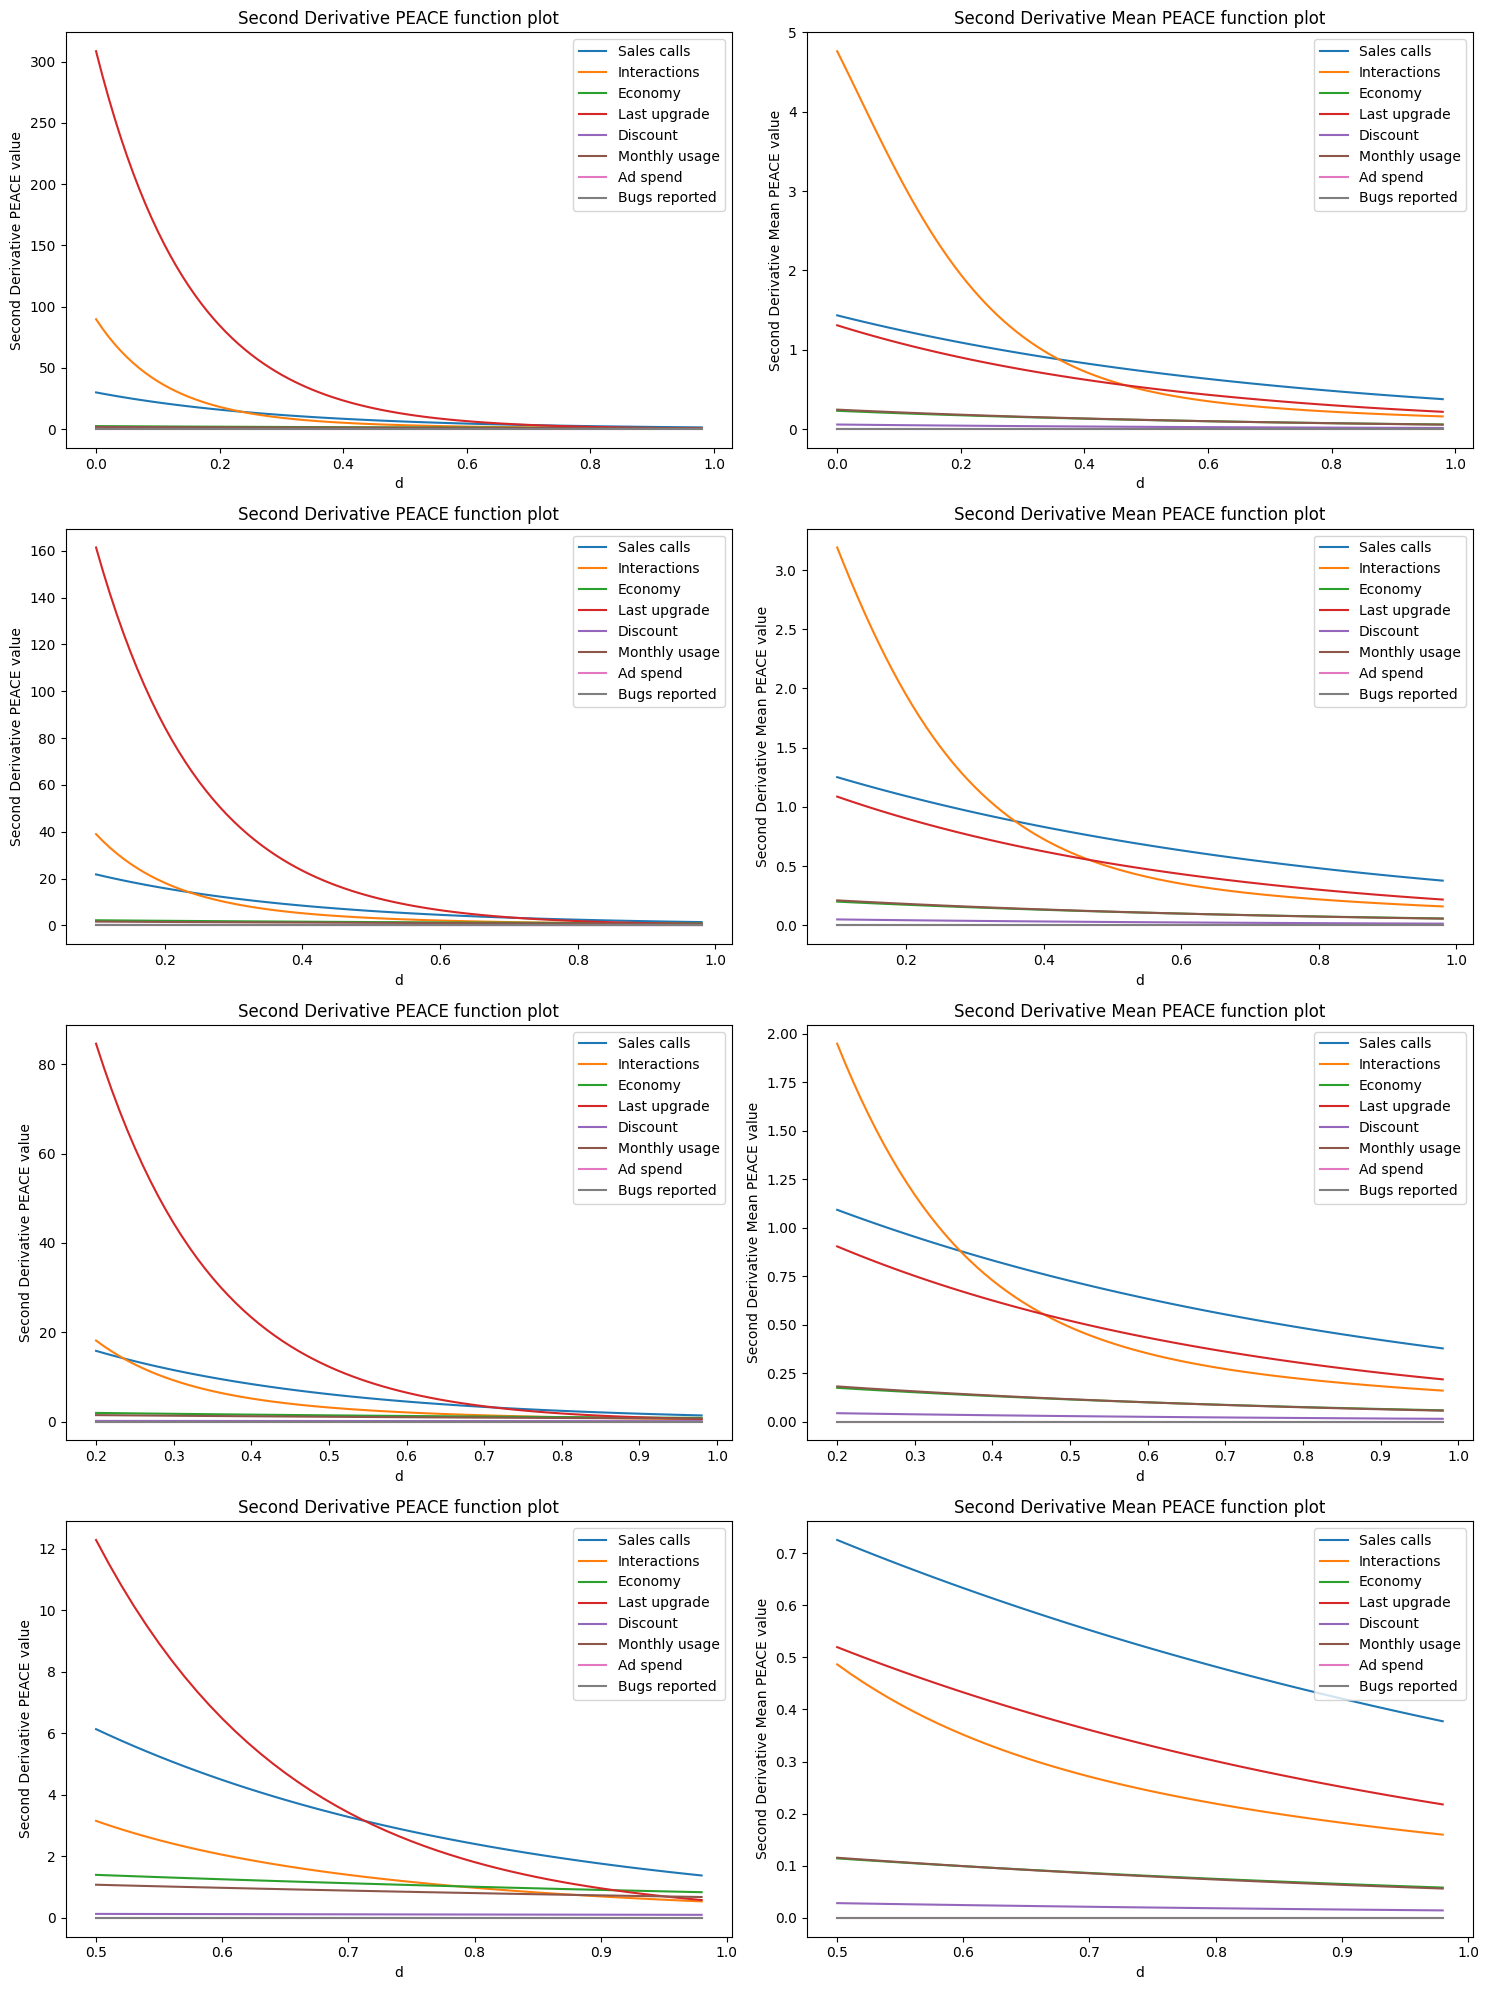

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

plot_ranges = [(0, 1), (0.1, 1), (0.2, 1), (0.5,1)]
for i, (start, end) in enumerate(plot_ranges):
    plot_values('second derivative', axs[i, 0], second_derivative_peace_values, start, end, step, 'Second Derivative PEACE value', 'Second Derivative PEACE function plot')
    plot_values('second derivative', axs[i, 1], second_derivative_mean_peace_values, start, end, step, 'Second Derivative Mean PEACE value', 'Second Derivative Mean PEACE function plot')

plt.tight_layout()
plt.show()

The second derivative of the PEACE function graph for a variable with respect to the outcome at a specific degree $d_0$ illustrates the acceleration at which PEACE decreases for values around $d_0$ (the left graph of the above Figures). This concept similarly applies to MEAN PEACE (the right graph). Therefore, up to a degree approximately equal to 0.7, the decline in PEACE associated with the "last upgrade" is more rapid than that of other variables. Beyond this threshold, the rate of decrease in the PEACE value for "sales calls" surpasses that of the other variables. **This indicates that, in the case of "sales calls", when the more frequent changes become increasingly important, their contribution to the PEACE metric- a measure of causal effect-diminishes more rapidly.**
Additionally, it is observed that the MEAN PEACE for "sales calls" consistently declines at a faster rate compared to others.

Economy and Last Upgrade: The decline in the PEACE values for these variables is also quite pronounced, indicating that changes in the "economy" and the timing of the "last upgrade" are more influential when they are less common. As these events become more common, their unique impact on the outcome lessens.

Discount and Monthly Usage: These variables show a more gradual decline in PEACE values, suggesting a more consistent influence across different levels of event availability. This means that both common and rare changes in "Discounts" and "Monthly Usage" have a relatively stable impact on the outcome.

Ad Spend and Bugs Reported: These two variables exhibit a very flat curve, especially for "Ad spend", due to the flatness of their original PEACE and MEAN PEACE graphs.


# Positive and Negative PEACEs

Now, for each real number $r$, define $r^+$ as the maximum of $0$ and $r$, and $r^-$ as the absolute value of $r$ minus $r^+$. For instance, we have that

*   $5^+ = \max\{5, 0\} = 5$,   
*   $5^- = |5| - 5^+ = 5 - 5 = 0 $

and

*   $ (-5)^+ = \max\{-5, 0\} = 0$,  
*   $ (-5)^- = |-5| - (-5)^+ = 5 $.

Subsequently, the positive and the negative PEACEs of degree $d$ are delineated as follows:
\begin{equation*}
\text{Positive PEACE}:\quad \sum_{i=1}^{l} \left(\mathbb{E}[g_{\text{in}}(t_i, C)] - \mathbb{E}[g_{\text{in}}(t_{i-1}, C)]\right)^+ \cdot P(t_i)^d \cdot P(t_{i-1})^d
\end{equation*}
\begin{equation*}
\text{Negative PEACE}:\quad \sum_{i=1}^{l} \left(\mathbb{E}[g_{\text{in}}(t_i, C)] - \mathbb{E}[g_{\text{in}}(t_{i-1}, C)]\right)^- \cdot P(t_i)^d \cdot P(t_{i-1})^d
\end{equation*}
The positive and the negative PEACEs are used to measure the total positive causal changes of $Y$ while increasing the value of $T$.


In the subsequent sections, we apply the methodology previously utilized for PEACE and MEAN PEACE to both their positive and negative variants. Specifically, we replace the use of absolute values with the employment of the "positive" and "negative" functions, as defined in the forthcoming discussion.


In [ ]:
def positive(r):
  return max(r,0)

def PEACE_positive(d):
  peace_positive = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += positive(result[index][1][i] - result[index][1][i-1])*((4*pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1])**d))
      peace_positive[c] = effect
  return peace_positive

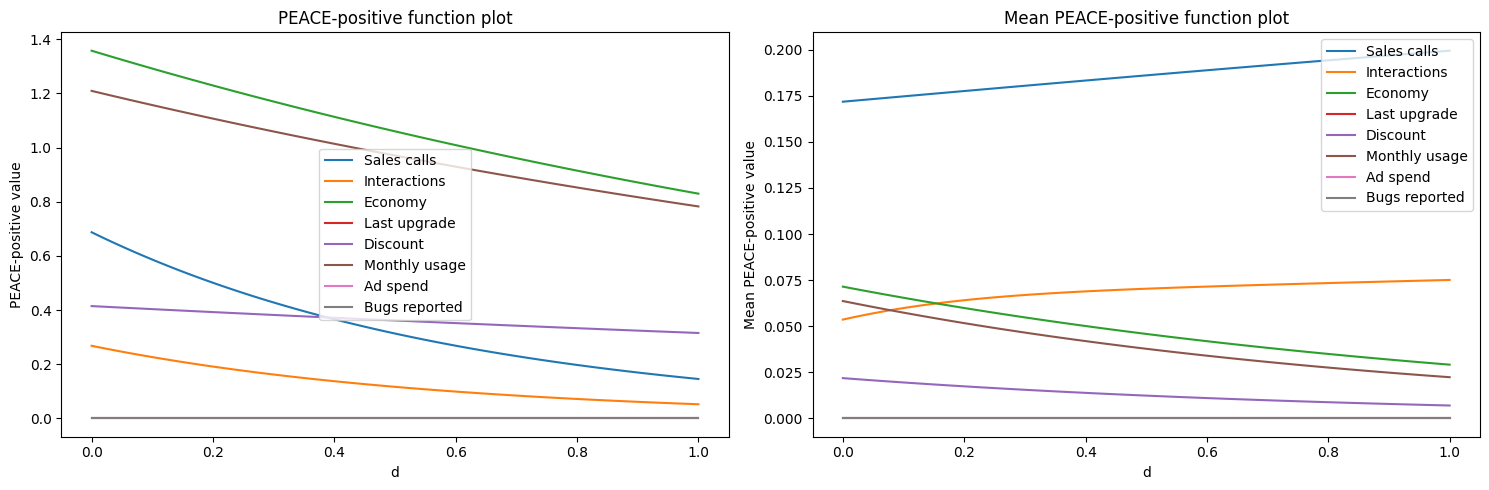

In [ ]:
peace_positive_values = {c: [PEACE_positive(d)[c] for d in d_values] for c in data.columns}
mean_peace_positive_values = {c: np.array(peace_positive_values[c]) / np.array(availability_values[c]) for c in data.columns}


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_values('ordinary', axs[0], peace_positive_values, 0, 1, step, 'PEACE-positive value', 'PEACE-positive function plot')
plot_values('ordinary', axs[1], mean_peace_positive_values, 0, 1, step, 'Mean PEACE-positive value', 'Mean PEACE-positive function plot')

plt.tight_layout()
plt.show()

In this analysis, the positive PEACE associated with the "economy" variable consistently ranks as the most substantial, whereas for MEAN positive PEACE, "sales calls" exhibit the greatest impact. Interestingly, the positive PEACE and the MEAN positive PEACE values for both "bugs reported" and "ad spend" align with zero, contradicting interpretations derived from Shapley values. Moreover, as the analysis incorporates more frequent values, "discount" surpasses "sales calls" in terms of positive PEACE. Simultaneously, in the MEAN positive PEACE metric, "interactions" surpass both the "economy" variable and "monthly usage".

**Additionally, the analysis reveals that the Discount variable exerts a positive influence on the outcome.**



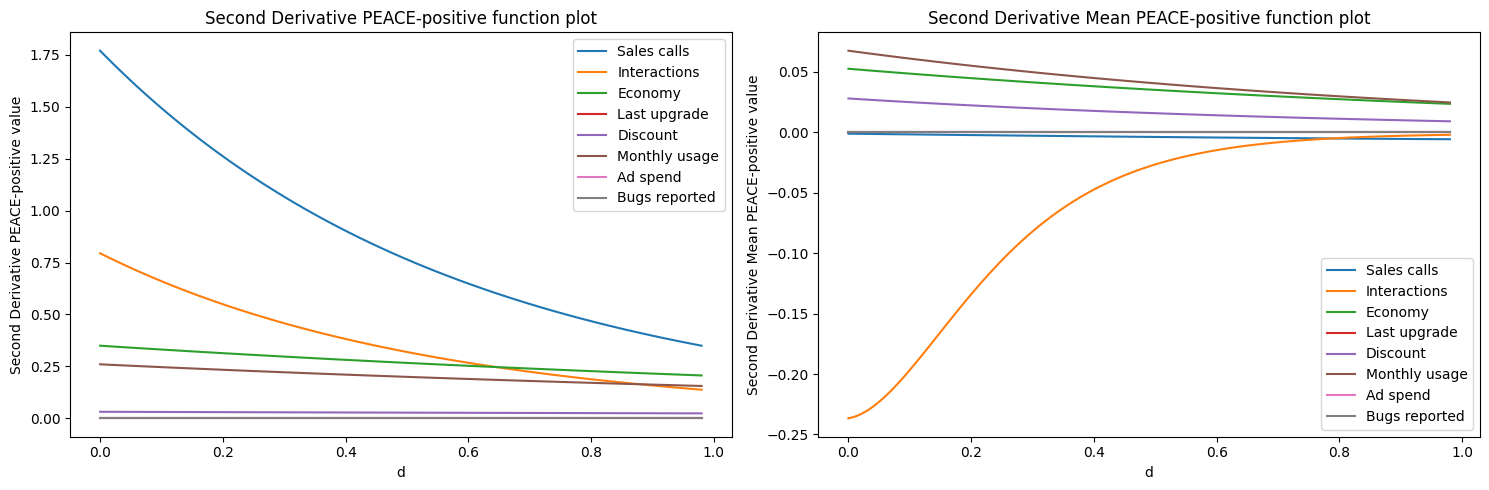

In [ ]:
derivative_peace_positive_values = calculate_derivative(peace_positive_values, step)
derivative_mean_peace_positive_values = calculate_derivative(mean_peace_positive_values, step)

second_derivative_peace_positive_values = calculate_derivative(derivative_peace_positive_values, step)
second_derivative_mean_peace_positive_values = calculate_derivative(derivative_mean_peace_positive_values, step)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_values('second derivative', axs[0], second_derivative_peace_positive_values, 0, 1, step, 'Second Derivative PEACE-positive value', 'Second Derivative PEACE-positive function plot')
plot_values('second derivative', axs[1], second_derivative_mean_peace_positive_values, 0, 1, step, 'Second Derivative Mean PEACE-positive value', 'Second Derivative Mean PEACE-positive function plot')

plt.tight_layout()
plt.show()

In this analysis, it is observed that the positive PEACE associated with sales calls declines more rapidly than that of other variables. Conversely, when examining MEAN positive PEACE, the rate of decline is more pronounced for monthly usage, whereas sales calls experience one of the slowest rates of decrease in this regard.


In [ ]:
def negative(r):
  return max(-r,0)

def PEACE_negative(d):
  peace_negative = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += negative(result[index][1][i] - result[index][1][i-1])*((4*pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1])**d))
      peace_negative[c] = effect
  return peace_negative

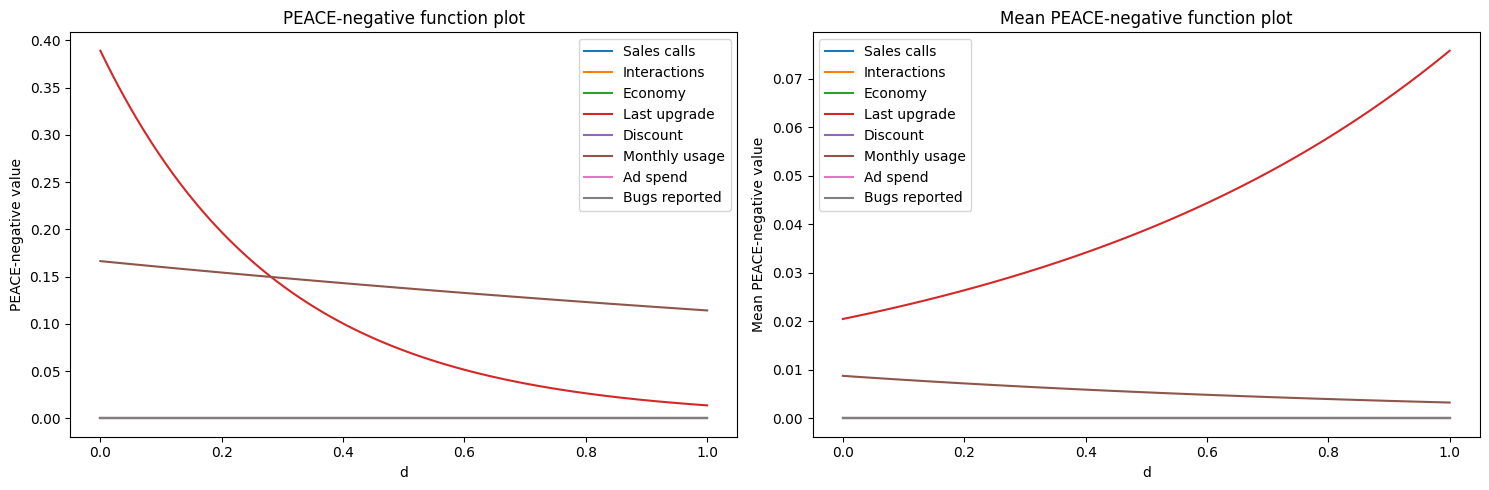

In [ ]:
peace_negative_values = {c: [PEACE_negative(d)[c] for d in d_values] for c in data.columns}
mean_peace_negative_values = {c: np.array(peace_negative_values[c]) / np.array(availability_values[c]) for c in data.columns}


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_values('ordinary', axs[0], peace_negative_values, 0, 1, step, 'PEACE-negative value', 'PEACE-negative function plot')
plot_values('ordinary', axs[1], mean_peace_negative_values, 0, 1, step, 'Mean PEACE-negative value', 'Mean PEACE-negative function plot')

plt.tight_layout()
plt.show()

For all variables except Last Upgrade and Monthly Usage, both the negative PEACE and the MEAN negative PEACE are zero. This indicates that minor increases in these variables do not negatively affect the outcome value. The declining trend lines imply that with the increase in event availability, the negative impact associated with each feature generally diminishes. Specifically for negative PEACE, apart from when the degree of importance is below approximately 0.3, Monthly Usage exhibits a higher negative PEACE compared to Last Upgrade across other degrees of importance. This suggests that when less common events are deemed less critical in the causal analysis, Monthly Usage's negative impact becomes more pronounced. Conversely, the situation is inverted for MEAN PEACE, where notably, the MEAN negative PEACE for Last Upgrade is on the rise. This trend is attributed to significant outcome changes driven by alterations in Last Upgrade's value, alongside the growing relative availability of these changes as $d$ increases.

**Furthermore, it is observed that the Discount variable does not exert any negative influence on the outcome, reinforcing the previously noted positive impact. Therefore, the influence of Discount is entirely positive, which contrasts with interpretations suggested by Shapley values.**



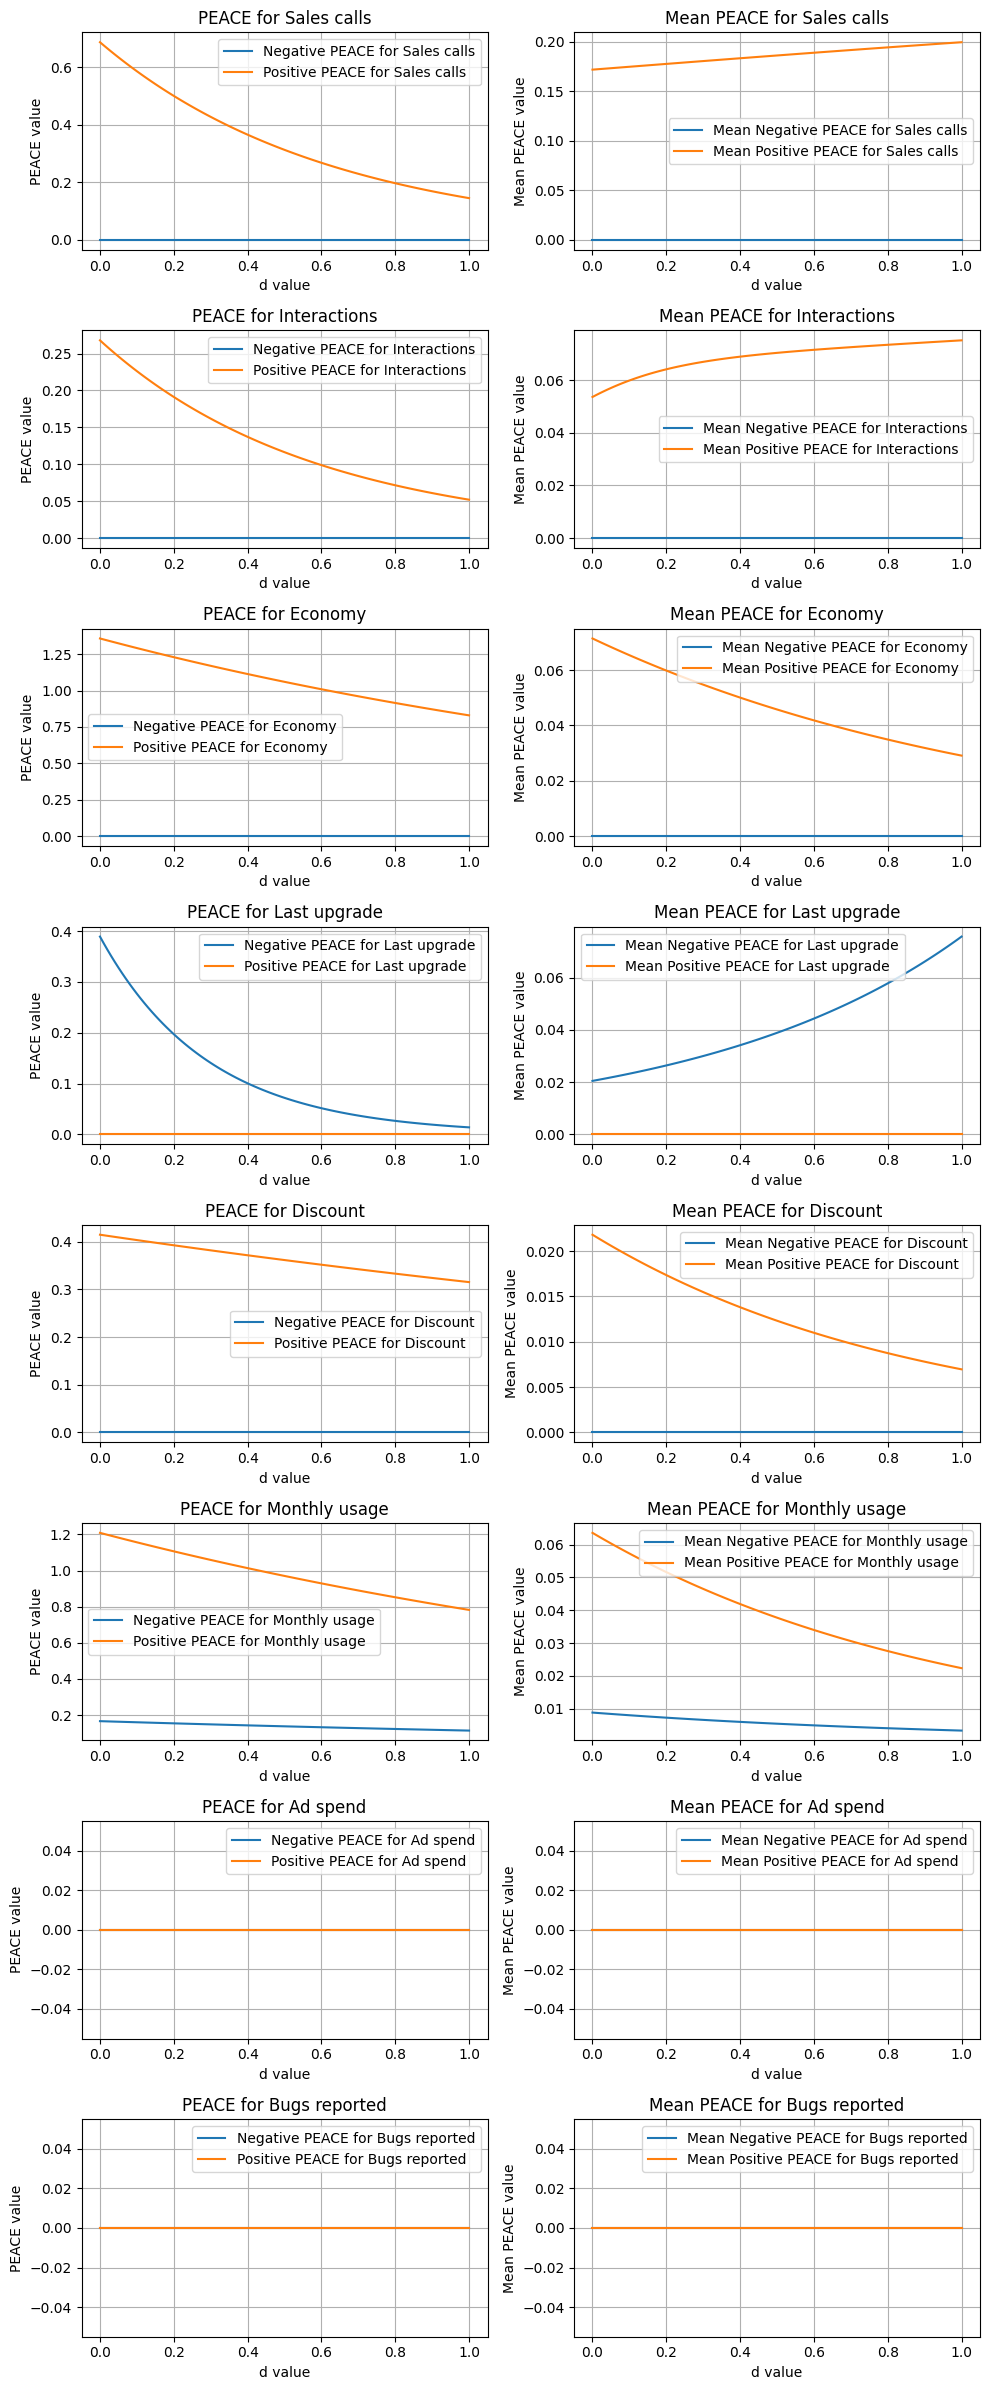

In [ ]:
num_variables = len(data.columns)
fig, axs = plt.subplots(num_variables, 2, figsize=(10, 3 * num_variables))

for i, c in enumerate(data.columns):
    # Adjust for when there's only one variable to avoid indexing errors
    ax_peace = axs[i, 0] if num_variables > 1 else axs[0]
    ax_mean_peace = axs[i, 1] if num_variables > 1 else axs[1]

    # Plot negative and positive PEACE values
    if c in peace_negative_values:
        ax_peace.plot(d_values, peace_negative_values[c], label=f'Negative PEACE for {c}')
    if c in peace_positive_values:
        ax_peace.plot(d_values, peace_positive_values[c], label=f'Positive PEACE for {c}')

    # Plot negative and positive mean PEACE values
    if c in mean_peace_negative_values:
        ax_mean_peace.plot(d_values, mean_peace_negative_values[c], label=f'Mean Negative PEACE for {c}')
    if c in mean_peace_positive_values:
        ax_mean_peace.plot(d_values, mean_peace_positive_values[c], label=f'Mean Positive PEACE for {c}')

    # Set labels, titles, legends, and grids for PEACE
    ax_peace.set_xlabel('d value')
    ax_peace.set_ylabel('PEACE value')
    ax_peace.set_title(f'PEACE for {c}')
    ax_peace.legend()
    ax_peace.grid(True)

    # Set labels, titles, legends, and grids for mean PEACE
    ax_mean_peace.set_xlabel('d value')
    ax_mean_peace.set_ylabel('Mean PEACE value')
    ax_mean_peace.set_title(f'Mean PEACE for {c}')
    ax_mean_peace.legend()
    ax_mean_peace.grid(True)

plt.tight_layout()
plt.show()

## References

[1] Lundberg, Scott, E. Dillon, J. LaRiviere, J. Roth, and V. Syrgkanis. "Be careful when interpreting predictive models in search of causal insights." Towards Data Sci (2021): 1-15.

[2] Faghihi, Usef, and Amir Saki. "Probabilistic Easy Variational Causal Effect." arXiv preprint arXiv:2403.07745 (2024).